# Rezky Adrianshah
# 2300588

In [2]:
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras import Sequential, Model
from keras.layers import Embedding, Concatenate, Dense,ZeroPadding2D, Conv2D, Reshape,BatchNormalization, Activation, Input, LeakyReLU, Dropout, Flatten, Conv2DTranspose, UpSampling2D
import plotly as px
from scipy.ndimage import rotate, shift
from numpy.random import randn
from numpy.random import randint
from collections import Counter
from tensorflow.keras.losses import KLDivergence


### Test load and generate for ACGAN

In [3]:
class ACGAN:
    def __init__(self, rows, cols, channels, z=100, num_classes=26):
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.record = pd.DataFrame(columns=['G_loss', 'D_loss', 'KL_divergence'])
        self.kl_metrics = KLDivergence()
        self.kl_history = []
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z
        self.num_classes = num_classes
        self.discriminator = self.define_discriminator(self.img_shape, self.num_classes)
        self.generator = self.define_generator(self.latent_dim, self.num_classes)
        z = Input(shape=(self.latent_dim,))
        self.discriminator.trainable = False
        self.combined = self.define_gan(self.generator, self.discriminator)

    def define_discriminator(self, in_shape, n_classes):
        init = RandomNormal(stddev=0.02)
        in_image = Input(shape=in_shape)
        fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Dropout(0.5)(fe)
        fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
        fe = BatchNormalization()(fe)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Dropout(0.5)(fe)
        fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
        fe = BatchNormalization()(fe)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Dropout(0.5)(fe)
        fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
        fe = BatchNormalization()(fe)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Dropout(0.5)(fe)
        fe = Flatten()(fe)
        out1 = Dense(1, activation='sigmoid')(fe)
        out2 = Dense(n_classes, activation='softmax')(fe)
        model = Model(in_image, [out1, out2])
        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
        return model

    def define_generator(self, latent_dim, n_classes):
        init = RandomNormal(stddev=0.02)
        in_label = Input(shape=(1,))
        li = Embedding(n_classes, 50)(in_label)
        n_nodes = 7 * 7
        li = Dense(n_nodes, kernel_initializer=init)(li)
        li = Reshape((7, 7, 1))(li)
        in_lat = Input(shape=(latent_dim,))
        n_nodes = 256 * 7 * 7
        gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
        gen = Activation('relu')(gen)
        gen = Reshape((7, 7, 256))(gen)
        merge = Concatenate()([gen, li])
        gen = Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', kernel_initializer=init)(merge)
        gen = Activation('relu')(gen)
        gen = Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
        gen = Activation('relu')(gen)
        gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
        out_layer = Activation('tanh')(gen)
        model = Model([in_lat, in_label], out_layer)
        return model

    def define_gan(self, g_model, d_model):
        for layer in d_model.layers:
            if not isinstance(layer, BatchNormalization):
                layer.trainable = False

        gan_output = d_model(g_model.output)
        model = Model(g_model.input, gan_output)
        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.summary()
        model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
        return model

    def save_imgs(self, epoch):
        r, c = 10, 10
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        sampled_labels = np.arange(0, r * c).reshape(-1, 1) % self.num_classes
        gen_imgs = self.generator.predict([noise, sampled_labels])
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        plt.suptitle(f"ACGAN (Epoch {epoch})", fontsize=16)
        os.makedirs('ACGAN', exist_ok=True)
        fig.savefig(f"ACGAN/ACGAN_{epoch}.png")
        plt.close()

    def generate_latent_points(self, latent_dim, n_samples, n_classes=26):
        x_input = randn(latent_dim * n_samples)
        z_input = x_input.reshape(n_samples, latent_dim)
        labels = randint(0, n_classes, n_samples)
        return [z_input, labels]

    def train(self, epochs=100, batch_size=1024, save_interval=1):
        X_train = X_pre  # Assuming X_pre is defined globally
        y_train = y_pre  # Assuming y_pre is defined globally

        batches_per_epoch = X_train.shape[0] // batch_size

        for epoch in range(epochs):
            for batch in range(batches_per_epoch):
                # Train discriminator on the first batch of real images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                labels_real = np.ones((batch_size, 1))

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_labels = np.random.randint(0, self.num_classes, (batch_size, 1))
                gen_imgs = self.generator.predict([noise, gen_labels])
                labels_fake = np.zeros((batch_size, 1))

                d_loss_real = self.discriminator.train_on_batch(imgs, [labels_real, y_train[idx]])
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [labels_fake, gen_labels])
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                z_input, z_labels = self.generate_latent_points(self.latent_dim, batch_size)
                y_gan = np.ones((batch_size, 1))
                g_loss = self.combined.train_on_batch([z_input, z_labels], [y_gan, z_labels])

                kl_div = self.kl_metrics(imgs, gen_imgs).numpy()
                self.kl_history.append(kl_div)
                print(f"Epoch {epoch + 1}/{epochs}, Batch {batch + 1}/{batches_per_epoch} [D loss: {d_loss}, G loss: {g_loss}]")

            if epoch % save_interval == 0:
                self.save_imgs(epoch + 1)

            new_row = pd.DataFrame({'G_loss': [g_loss[0]], 'D_loss': [d_loss[0]], 'KL_divergence': [kl_div]})
            self.record = pd.concat([self.record, new_row], ignore_index=True)

        plot_learning_curves(self.record)
        self.combined.save_weights('ACGAN_Combi.h5')
        self.generator.save_weights('ACGAN_Gen.h5')
        self.discriminator.save_weights('ACGAN_Disc.h5')


In [ ]:
acgan = ACGAN(rows=28, cols=28, channels=1, z=100, num_classes=26)

acgan.generator.load_weights('ACGAN Improved/ACGAN_Gen.h5')
acgan.discriminator.load_weights('ACGAN Improved/ACGAN_Disc.h5')
acgan.combined.load_weights('ACGAN Improved/ACGAN_Combi.h5')

c:\Users\rezky\anaconda3\envs\devops_env\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 12544)     │  1,266,944 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 50)     │      1,300 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 12544)     │          0 │ dense_3[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 49)     │      2,499 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 7, 7, 256) │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 7, 7, 1)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7, 7, 257) │          0 │ reshape_1[0][0],  │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 14, 14,    │    411,264 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 14, 14,    │          0 │ conv2d_transpose… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 28, 28, 1) │      1,601 │ activation_2[0][… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 28, 28, 1) │          0 │ conv2d_transpose… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 1),       │    728,347 │ activation_3[0][… │
│ (Functional)        │ (None, 26)]       │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,411,955 (9.20 MB)

 Trainable params: 1,683,608 (6.42 MB)

 Non-trainable params: 728,347 (2.78 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


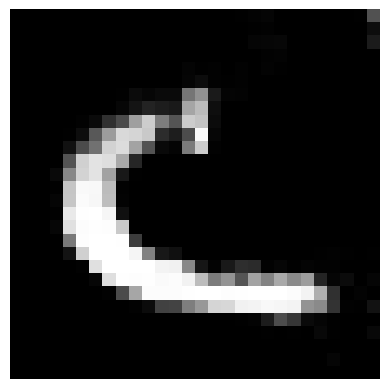

In [12]:
# Generate latent points for a specific letter (e.g., 'A')
z_input = np.random.normal(0, 1, (1, acgan.latent_dim))  # Random noise for the generator
label = np.array([[2]])  # 'A' could correspond to label 0

# Generate the image for the letter 'A'
generated_image = acgan.generator.predict([z_input, label])

# Display the generated image
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()

In [16]:
# Generate latent points for a specific letter (e.g., 'A')
z_input = np.random.normal(0, 1, (1, acgan.latent_dim))  # Random noise for the generator
label = np.array([[4]])  # 'A' could correspond to label 0

# Generate the image for the letter 'A'
generated_image = acgan.generator.predict([z_input, label])

# Run the discriminator on the generated image
real_fake, predicted_class = acgan.discriminator.predict(generated_image)

# Extract the predicted class (the second output from the discriminator)
predicted_class = np.argmax(predicted_class, axis=1)

# Print the predicted class
print(f"Predicted class (letter): {predicted_class[0]}")  # This will give the class index (0-25)

# Optionally, map the class index back to the letter (if needed)
letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
predicted_letter = letters[predicted_class[0]]
print(f"Predicted letter: {predicted_letter}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted class (letter): 4
Predicted letter: E


### Now that models have been tested, we can save them in the SavedModel format for tensorflow/serving.

In [19]:
acgan.generator.export('ACGAN_Gen_SavedModel/1')

# Save the Discriminator model
acgan.discriminator.export('ACGAN_Disc_SavedModel/1')

INFO:tensorflow:Assets written to: ACGAN_Gen_SavedModel/1\assets


INFO:tensorflow:Assets written to: ACGAN_Gen_SavedModel/1\assets


Saved artifact at 'ACGAN_Gen_SavedModel/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 100), dtype=tf.float32, name='keras_tensor_23'), TensorSpec(shape=(None, 1), dtype=tf.float32, name='keras_tensor_19')]
Output Type:
  TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)
Captures:
  1727276657232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727276656080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727276658192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727276658000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727276657424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727276656464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727276659728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727276656848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727276660496: TensorSpec(shape=(), dtype=tf.resource, name=None)
INFO:tensorflow:As

INFO:tensorflow:Assets written to: ACGAN_Disc_SavedModel/1\assets


Saved artifact at 'ACGAN_Disc_SavedModel/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  List[TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)]
Captures:
  1727275609616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727275609232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727194239376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727275610576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727275611536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727275608848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727275609424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727275610192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727275612112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1727275612880: TensorSpec(shape=